Aproximación directa del problema, vamos a suponer una solución

$$ y = a_0 + a_1 x_{t} + a_2 x_{t-1} + \dots + a_{m+1} x_{t-m}$$

Donde m es el tamaño de la ventana temporal, número de pasos anteriores que vamos a usar.

La aproximación la haremos a un paso, es decir $y = x_{t+1}$. Con la misma filosofía se podria asumir que $y = x_{t+n}$ si queremos hacer una aproximacion a n pasos.

EL error que usaremos será el cuádratico medio. Teniendo en cuenta que los datos tienen que estar normalizados, la función de coste sería:

$$ C_P = (1 - < y , h(x) >)^2 $$

Donde h_(x) es la predicción a un paso. Estamos basándonos en la implementación de Quiskit de una circuito variacional que halla polinomios [1](https://learn.qiskit.org/course/ch-demos/variational-quantum-regression)

La optimización se realizará por descenso del gradiente estocástico. La derivada parcial repecto a los pesos son:

$$ \dfrac{\partial C_P}{ \partial a_0} = 2(1 - <y,1>) $$
$$ \dfrac{\partial C_P}{ \partial a_i} = 2(1 - <y,h(x)>) <y , x_{t-i-1}> $$

Luego la actualización de los pesos sería:

$$ \begin{pmatrix} a_0^{i+1} \\ a_1^{i+1} \\ \vdots \\a_{m+1}^{i+1} \end{pmatrix} = 
    \begin{pmatrix} a_0^{i} \\ a_1^{i} \\ \vdots \\a_{m+1}^{i} \end{pmatrix} - 
    \eta \dfrac{2}{M}\sum_{j=1}^M \begin{pmatrix} (1 - <y_j,1>) \\ (1 - <y_j,h(x_j)>) <y_j , x_{j,t-i-1}> \\ \vdots \\ (1 - <y_j,h(x_j)>) <y_j , x_{j,t-m}>\end{pmatrix}
$$

Donde M es el tamaño del Batch, el cálculo del producto escalar lo haremos en un computador cuántico

In [1]:
# Para manejo de datos Clásicos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from datetime import datetime

# Qiskit
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
import math
import random



Procesemos todos los datos, se pondra directamente todo, en otro Note book se ve paso por paso

In [2]:
df=pd.read_csv('./datos/AirPassengers.csv')
df['Month']=pd.to_datetime(df['Month'], infer_datetime_format=True)
df=df.set_index(['Month'])
df_log=np.log(df)
data_shift=df_log-df_log.shift()
data_shift = data_shift.dropna()

# Crear los conjuntos
ptrain=0.8
pasajeros = np.array(data_shift['#Passengers'])
pasajeros_train = pasajeros[:int(pasajeros.shape[0]*0.8)]
pasajeros_test = pasajeros[int(pasajeros.shape[0]*0.8):]

tiempo = data_shift.drop(['#Passengers'], axis=1)
tiempo_train = tiempo.head(int(pasajeros.shape[0]*0.8))
tiempo_test = tiempo.tail(pasajeros.shape[0] - int(pasajeros.shape[0]*0.8))

# Pasemos a numpy
window = 12;
tam_train = pasajeros_train.shape[0] - window
tam_test = pasajeros_test.shape[0] - window
conjunto_train = []
objetivo_train = []
conjunto_test = []
objetivo_test = []

for i in range(0,tam_train):
    conjunto_train.append(pasajeros_train[0+i:window+i])
    objetivo_train.append(pasajeros_train[window+i])

for i in range(0,tam_test):
    conjunto_test.append(pasajeros_test[0+i:window+i])
    objetivo_test.append(pasajeros_test[window+i])
    
objetivo_train = np.array(objetivo_train)
conjunto_train = np.array(conjunto_train)

objetivo_test = np.array(objetivo_test)
conjunto_test = np.array(conjunto_test)

# Definir los batches de entrenamiento, voy a cogerlos consecutivos
batch_size = 32

batchs_conjunto = []
batchs_objetivo = []

n_batch = conjunto_train.shape[0]//batch_size

for i in range(0,n_batch):
    batchs_conjunto.append( conjunto_train[batch_size*i:batch_size*(i+1)] )
    batchs_objetivo.append( objetivo_train[batch_size*i:batch_size*(i+1)] )


batchs_conjunto.append( conjunto_train[batch_size*n_batch:] )
batchs_objetivo.append( objetivo_train[batch_size*n_batch:] )
n_batch = n_batch+1

Función que calcula el producto interno entre dos vectores, en particular elementos

In [3]:
window = 12
nqubits = math.ceil(np.log2(window))
def inner_prod(vec1, vec2):
    #first check lengths are equal
    if len(vec1) != len(vec2):
        raise ValueError('Lengths of states are not equal')
        
    circ = QuantumCircuit(nqubits+1,1)
    vec = np.concatenate((vec1,vec2))/np.sqrt(2)
    if(len(vec) != 2**(nqubits+1)):
        vec = np.concatenate((vec,np.zeros(2**(nqubits+1) - len(vec))))
    
    circ.initialize(vec, range(nqubits+1))
    circ.h(nqubits)
    circ.measure(nqubits,0)

    backend = Aer.get_backend('qasm_simulator')
    job = execute(circ, backend, shots=20000)

    result = job.result()
    outputstate = result.get_counts(circ)

    if ('0' in outputstate.keys()):
        m_sum = float(outputstate["0"])/20000
    else:
        m_sum = 0
     
    return 2*m_sum-1

Cambio de paradigma, VAMOS a usar el error cuadrático medio normal, necesitamos calcular el producto escalar entre a y X

In [4]:
# Entrenamiento

eta = 0.01
n_epoc = 2000
a_init = np.zeros(window+1)
a_next = a_init

error = []

for i in range(0,n_epoc): # Cada epoca
    
    for j in range(0,n_batch): # Cada batch
        suma = np.zeros(window+1)
        for s in range(0,batchs_conjunto[j].shape[0]): #Cada elemento del batch
            norma_a = np.linalg.norm(a_next)
            aux = np.insert(batchs_conjunto[j][s],0,1)
            norma_aux = np.linalg.norm(aux)
            producto = 0
            if(norma_a*norma_aux != 0):
                producto = inner_prod(aux/norma_aux, a_next/norma_a)*norma_aux*norma_a
                #producto = aux @ a_next.T 
                
            suma = suma +  aux*(producto - batchs_objetivo[j][s])
            
            
    a_next = a_next - eta * (2/n_batch) * suma

Veamos como de bien ha hido en entrenamiento (los datos estan transformados, para recuperarlos hay que destranformarlos

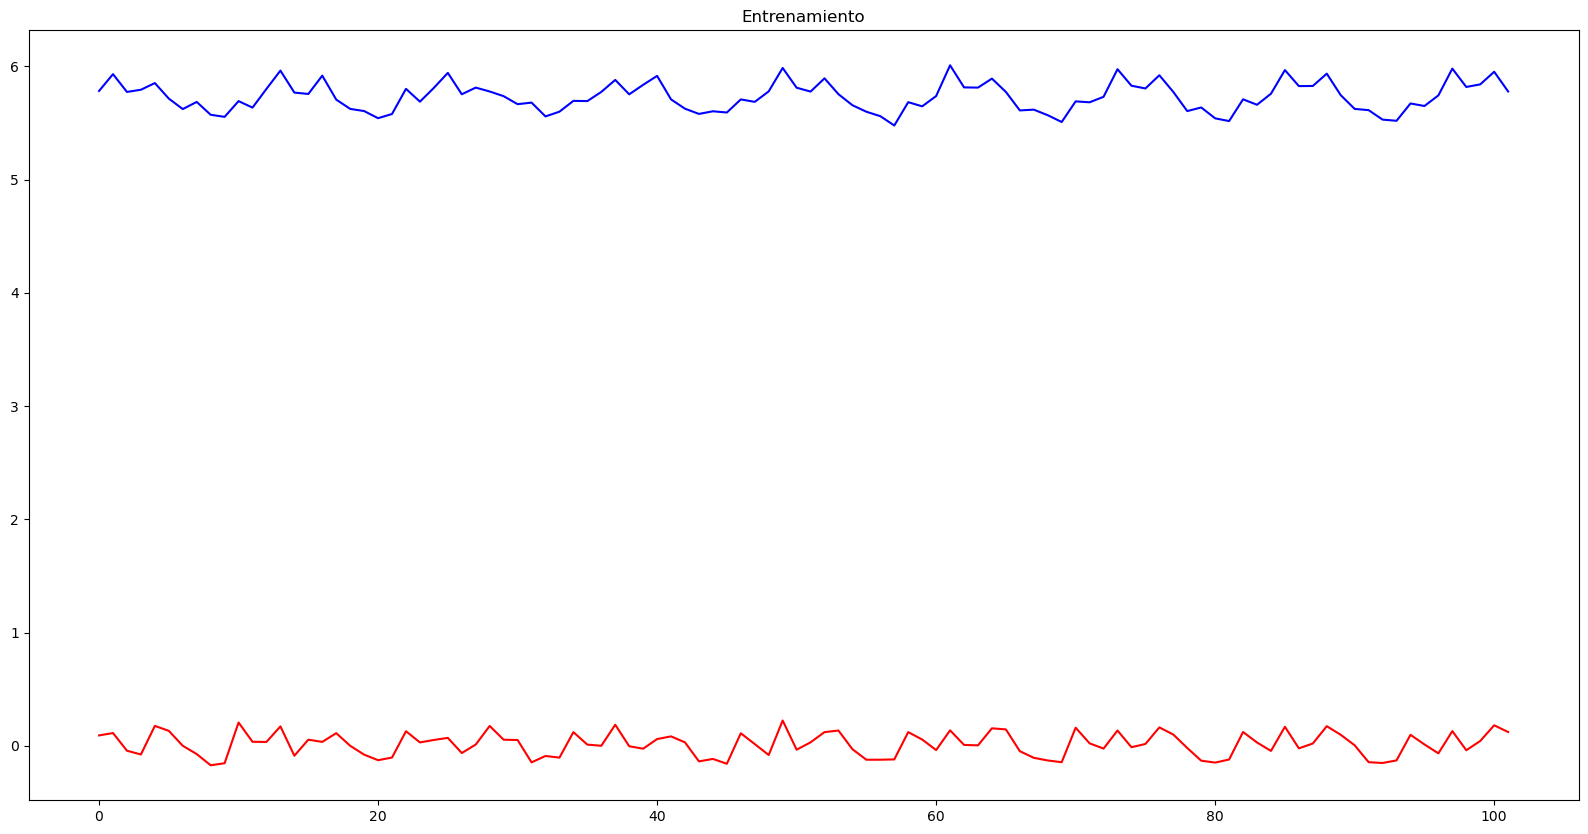

In [5]:
y_ = []
for i in range(0,conjunto_train.shape[0]):
    y_.append( 1*(np.insert(conjunto_train[i] ,0,1) @ a_next.T - 0) ) # Modificando la escala sale...
espacio = np.arange(0,objetivo_train.shape[0])
plt.figure(figsize=(20,10))
plt.plot(espacio ,objetivo_train, color='red', label='Verdaderos')
plt.plot(espacio,y_, color='blue', label='Predicciones')
plt.title("Entrenamiento")
plt.show()

Y la prueba final en test (los datos estan transformados, para recuperarlos hay que destranformarlos

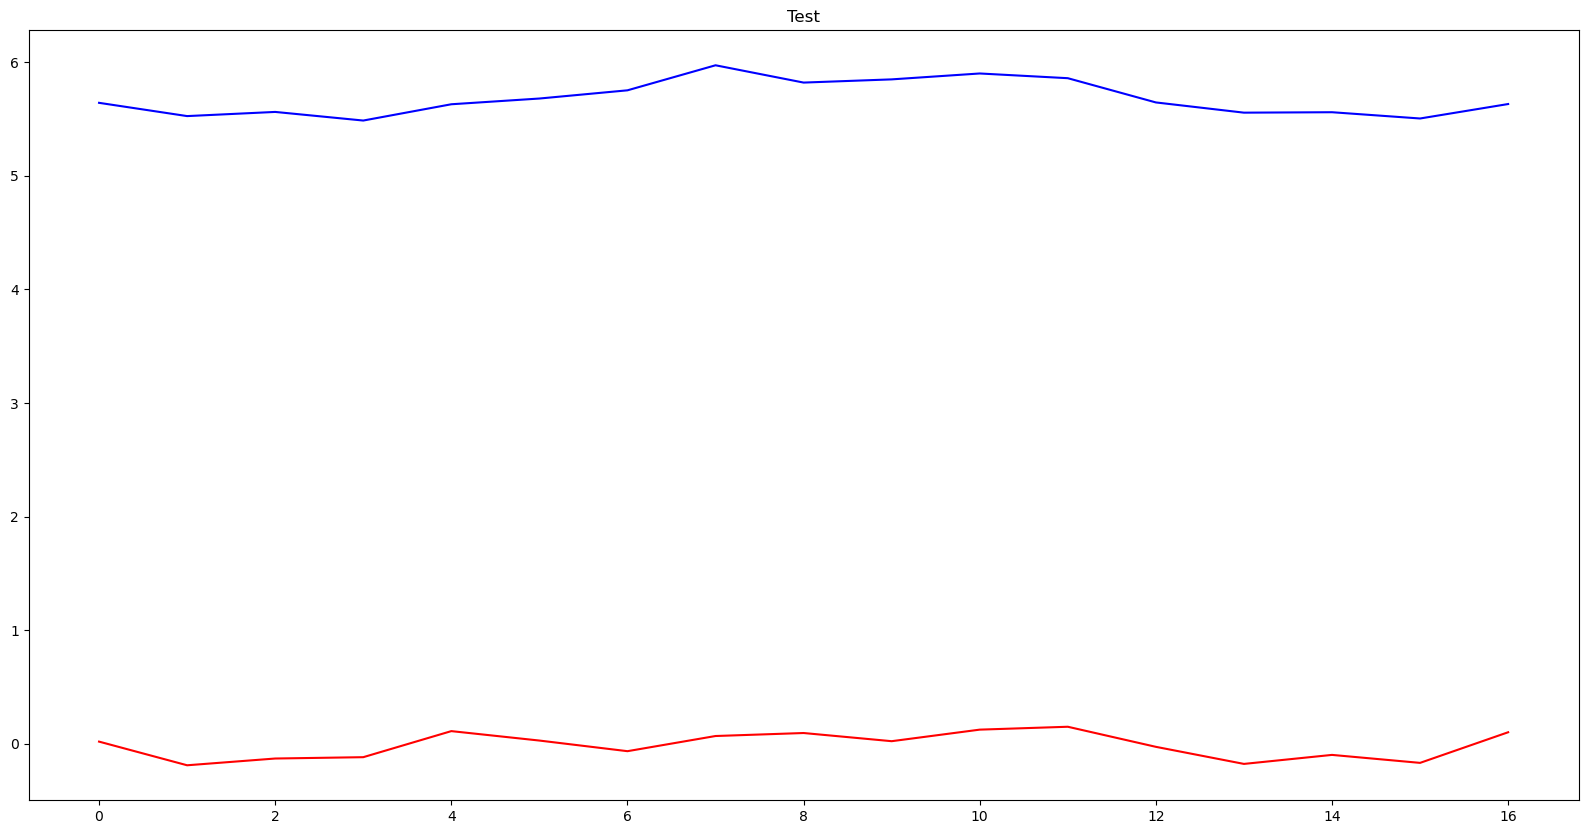

In [6]:
y_ = []
for i in range(0,conjunto_test.shape[0]):
    y_.append(np.insert(conjunto_test[i] ,0,1) @ a_next.T)
    
espacio = np.arange(0,objetivo_test.shape[0])
plt.figure(figsize=(20,10))
plt.plot(espacio ,objetivo_test, color='red', label='Verdaderos')
plt.plot(espacio,y_ , color='blue', label='Predicciones')
plt.title("Test")
plt.show()